# Introduction

Notre dataset comporte  46102 lignes correspondant chacune à une vidéo Youtube issue d'une parmi 58	 chaines de médias	 français. Nous avons 28 variables:	 
Chaque	 chaîne	 analysée	 appartient	 à	 une	 catégorie institutionnelle (Presse	
nationale,	régionale,	magazine,	médias	alternatifs,	pure-players,	TV)	et	est	aussi	catégorisée	
par	son	type	de	contenu	(« cœur »,	« niche » ou	« partisan »).

# Fonctions

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors, tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

In [2]:
sns.set_style('darkgrid')
plt.rc('figure', figsize=[12, 9])
scaler = StandardScaler()

In [3]:
nbr_columns = ['nbrMotInsulte', 'nbrMot', 'nbrMotAllong', 'nbrMotMAJ', 'nbrExclMark', 'nbrQuestMark']
comment_columns = ['message_count', 'thread_count', 'discussion_count']
auth_columns = ['distinct_authors_count', 'authors_3channels_count', 'liked_authors_count']
mean_columns = ['nbrMotMoyenne', 'nbrMotInsulteMoyenne', 'nbrMotAllongMoyenne',
                'nbrMotMAJMoyenne', 'nbrExclMarkMoyenne', 'nbrQuestMarkMoyenne']
num_columns = nbr_columns + comment_columns + auth_columns + ['subscriberCount', 'viewCount']
cat_columns = ['categorie_new', 'categ_inst']

In [4]:
# useful functions to plot and understand data

def describe_cat_data(df):
    mv = 'some' if df.isnull().values.any() else 'no'
    msg = 'We have ' + str(len(num_columns)) + ' numerical features and ' + str(len(cat_columns)) + \
          ' categorical features for ' + str(len(df.index)) + ' samples.\nThere are ' + mv + ' missing values in this dataset.\n'
    for c in cat_columns:
        plot_scatter(df, c)
        plot_categorical(df, c)


def describe_num_data(df):
    for c in num_columns:
        if c != 'nbrMotInsulte':
            plot_scatter(df, c)
        plot_hist(df, c)


def plot_scatter(df, feature):
    plt.figure()
    plt.title('Plot of number of insulting words by ' + feature)
    plt.scatter(df[feature], df['nbrMotInsulte'])
    plt.show()


def plot_hist(df, feature):
    plt.figure()
    plt.title('Plot of histogram of ' + feature)
    df[feature].hist()
    plt.show()


def plot_categorical(df, feature):
    counts = df[feature].value_counts(normalize=True)
    plt.figure()
    plt.title('Plot of the percentage of samples per distinct value of ' + feature)
    plt.bar(counts.index, counts, align='center', alpha=0.5)
    plt.xticks(counts.index, counts.index)
    plt.show()
    
    
def find_outliers(df, df2):
    for c in num_columns:
        plt.figure()
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('Boxplots of ' + c + ' for Youtube comments, with and without outliers')
        sns.boxplot(ax=ax1, data=df[c], fliersize=10)  # fliersize is the size used to indicate the outliers
        sns.boxplot(ax=ax2, data=df2[c], fliersize=10)
        plt.show()
        

def correlation_matrix(df, log=False):
    corr = df.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    # Generate a custom diverging colormap
    plt.figure()
    title = 'Correlation matrix for Youtube comments'
    if log:
        title += ' with log numerical values'
    plt.title(title)
    sns.heatmap(corr, mask=mask)
    plt.show()

In [5]:
# useful functions to create the dataset

# outputs the following list: [X_train, y_train, X_test, y_test]
def create_dataset(plot=False, log=False):
    df = load_dataset()
    if log:
        df = modify_num_data(df, plot)
    df = one_hot_encoding(df)
    df2 = df.sample(frac=0.8, random_state=123)  # must set a seed value in random_state option
    test = df.drop(df2.index, axis=0)
    train = remove_outliers(df)
    if plot:
        find_outliers(df, train)
        describe_num_data(train)
    X_train, y_train = data_and_label(train)
    X_train = normalize(X_train)
    X_test, y_test = data_and_label(test)
    X_test = normalize(X_test, False)
    print('dataset created')
    return [X_train, y_train, X_test, y_test]


def load_dataset():
    df = pd.read_csv('Dataset/challenge_youtube_toxic.csv', encoding ='unicode_escape', sep=';', decimal=',')
    # channel name does not seem relevant and will create a lot of dimensions with the one hot encoding
    df = df.drop(['channel_name', 'video_id', 'video_id_court', 'channel_id', 'Unnamed: 27'], axis=1)
    return df


def modify_num_data(df, plot):
    cols = nbr_columns + comment_columns + auth_columns
    df[cols] = df[cols].apply(lambda x: np.log(x+1))
    if plot:
        describe_num_data(df)
    return df



def remove_outliers(df, log=False):

    for c in nbr_columns:
        if c != 'nbrMot':
            df = df[df[c] <= 2000]
            df = df[df[c] <= 30 * df['message_count']]
        else:
            df = df[df[c] <= 400000]
            df = df[df[c] <= 1000*df['message_count']]

    '''# for the number of words or messages, we just leave out the very isolated ones
    df = df[df['nbrMot'] <= 400000]
    df = df[df['message_count'] <= 8000]
    df = df[df['distinct_authors_count'] <= 7500]
    df = df[df['subscriberCount'] <= 400000]'''
    return df


def one_hot_encoding(df):
    one_hot = pd.get_dummies(df[cat_columns])
    df = pd.concat([df, one_hot], axis=1)
    df = df.drop(cat_columns, axis=1)
    return df


def data_and_label(df):
    y = df['nbrMotInsulte']
    y = y.to_numpy()
    X = df.drop(['nbrMotInsulte'], axis=1)
    return [X, y]


def normalize(data, train=True):
    if train:
        scaler.fit(data)
    return pd.DataFrame(scaler.transform(data), columns=data.columns)

In [6]:
# functions useful for regression

def parameter_tuning(reg, grid, how='grid_search', cv=5, verbose=3, n_jobs=3):
    if how == 'grid_search':
        search = GridSearchCV(reg, grid, scoring='neg_mean_squared_error', cv=cv, verbose=verbose, n_jobs=n_jobs)
    else:
        search = RandomizedSearchCV(reg, grid, n_iter=10, scoring='neg_mean_squared_error',
                                    cv=cv, verbose=verbose, random_state=42, n_jobs=n_jobs)
    search.fit(X_train, Y_train)
    print('cross validation score of ' + str(search.best_estimator_) + ': ' + str(search.best_score_))
    scores_on_train[str(search.best_estimator_)] = search.best_score_
    return search.best_estimator_


def show_one_parameter(algo, param, values, kwargs=None, cv=5, n_jobs=3):
    if not kwargs:
        kwargs = {}
    scores = []
    reg = None
    for value in values:
        kwargs[param] = value
        reg = algo(**kwargs)
        scores.append(cross_val_score(reg, X_train, Y_train, scoring='neg_mean_squared_error',
                                      cv=cv, n_jobs=n_jobs, verbose=3).mean())
    plt.figure()
    plt.title('Negative mean squared error of ' + str(reg) + ' with tuning of ' + str(param))
    plt.plot(values, scores)
    plt.xlabel(param)
    plt.ylabel('Negative MSE')
    plt.show()


def plot_results(reg, log=False):
    y_pred = reg.predict(X_test)
    mse = mean_squared_error(y_pred, Y_test)
    r2 = r2_score(y_pred, Y_test)
    print('scores on test set')
    print('MSE: ', mse)
    print('r2: ', r2)
    ratio = ratio_of_right_predictions(y_pred, Y_test, log)
    print()
    sort_ind = np.argsort(Y_test)
    y1, y2 = [], []
    for ind in sort_ind:
        y1.append(y_pred[ind])
        y2.append(Y_test[ind])
    x = range(len(y1))
    plt.figure()
    plt.title('Confrontation with ground truth ' + str(reg))
    plt.plot(x, y1, color='r', label='prediction')
    plt.plot(x, y2, color='b', label='ground truth')
    plt.xlabel('ordered samples')
    plt.ylabel('number of insult words')
    plt.legend()
    plt.show()
    mse_on_test[str(reg)] = mse
    r2_on_test[str(reg)] = r2
    ratio_on_test[str(reg)] = ratio
    

def ratio_of_right_predictions(y_pred, Y_test, log):
    count = 0
    for i in range(len(Y_test)):
        if log:
            if abs(np.exp(Y_test[i]) - np.exp(y_pred[i])) < 0.5:
                count += 1
        else:
            if abs(Y_test[i] - y_pred[i]) < 0.5:
                count += 1
    ratio = count/len(Y_test)
    print('Ratio of right predictions: ', ratio)
    return ratio


def compare_scores():
    plt.figure()
    plt.title('Mean squared error obtained by cross validation on train set for every algorithms')
    plt.bar(*zip(*scores_on_train.items()))
    plt.show()

    plt.figure()
    plt.title('Mean squared error on test set for every algorithms')
    plt.bar(*zip(*mse_on_test.items()))
    plt.show()

    plt.figure()
    plt.title('Coefficient of determination on test set for every algorithms')
    plt.bar(*zip(*r2_on_test.items()))
    plt.show()
    
    if len(ratio_on_test) > 0:
        plt.figure()
        plt.title('Ratio of right predictions on test set for every algorithms')
        plt.bar(*zip(*ratio_on_test.items()))
        plt.show()

# Compréhension data

In [7]:
df = load_dataset()
df.head()

nbrMot  nbrMotInsulte  nbrMotAllong  nbrMotMAJ  nbrExclMark  nbrQuestMark  \
0    3813             18             4        145           79            60   
1      28              2             0          1            0             0   
2    3804             68             9         56           75            54   
3       4              0             1          2            0             0   
4     737              3             1         18            5             6   

   nbrMotMoyenne  nbrMotInsulteMoyenne  nbrMotAllongMoyenne  nbrMotMAJMoyenne  \
0      30.261900              0.142857             0.031746          1.150794   
1       9.333333              0.666667             0.000000          0.333333   
2      27.565220              0.492754             0.065217          0.405797   
3       2.000000              0.000000             0.500000          1.000000   
4      32.043478              0.130435             0.043478          0.782609   

   ...  comment_count  message_count  discussion_count  \
0  ...             81            126                28   
1  ...              0              3                 0   
2  ...             86            138                22   
3  ...              0              2                 0   
4  ...              6             23                 4   

   distinct_authors_count  authors_3channels_count  liked_authors_count  \
0                      58                       47                   23   
1                       3                        1                    0   
2                      83                       49                   36   
3                       2                        0                    0   
4                      18                        7                    7   

   subscriberCount  viewCount  categorie_new        categ_inst  
0           339922  225393312           Core      Pure Players  
1           189971  132125693           Core                TV  
2           339922  225393312           Core      Pure Players  
3             2862    2481100          Niche  Presse_regionale  
4            30010    6710737           Core  Presse nationale  

[5 rows x 23 columns]

In [8]:
df.describe()

nbrMot  nbrMotInsulte  nbrMotAllong     nbrMotMAJ   nbrExclMark  \
count   46102.000000   46102.000000  46102.000000  46102.000000  46102.000000   
mean     1435.853564       9.418225      3.974665     21.922823     21.823066   
std      7670.789422      61.616732     21.367879    130.038591    120.607203   
min         0.000000       0.000000      0.000000      0.000000      0.000000   
25%        18.000000       0.000000      0.000000      0.000000      0.000000   
50%        72.000000       0.000000      0.000000      0.000000      1.000000   
75%       398.000000       3.000000      1.000000      6.000000      9.000000   
max    662808.000000    7227.000000   1416.000000  14270.000000  11093.000000   

       nbrQuestMark  nbrMotMoyenne  nbrMotInsulteMoyenne  nbrMotAllongMoyenne  \
count  46102.000000   46102.000000          46102.000000         46102.000000   
mean      13.591276      25.264768              0.189175             0.080849   
std       68.803038      31.979351              0.444356             0.305948   
min        0.000000       0.000000              0.000000             0.000000   
25%        0.000000       9.769231              0.000000             0.000000   
50%        1.000000      18.630032              0.000000             0.000000   
75%        4.000000      31.000000              0.222222             0.068821   
max     5520.000000    1349.500000             14.000000            28.000000   

       nbrMotMAJMoyenne  ...  nbrQuestMarkMoyenne  thread_count  \
count      46102.000000  ...         46102.000000  46102.000000   
mean           0.583485  ...             0.276134     22.219145   
std            3.114312  ...             0.950349    117.441322   
min            0.000000  ...             0.000000      1.000000   
25%            0.000000  ...             0.000000      1.000000   
50%            0.000000  ...             0.040161      3.000000   
75%            0.400000  ...             0.333333      9.000000   
max          162.000000  ...           120.750000   8734.000000   

       comment_count  message_count  discussion_count  distinct_authors_count  \
count   46102.000000   46102.000000      46102.000000            46102.000000   
mean       25.700816      47.919960          5.040085               28.726021   
std       130.742237     234.791106         19.578795              140.334032   
min         0.000000       1.000000          0.000000                1.000000   
25%         0.000000       1.000000          0.000000                1.000000   
50%         0.000000       4.000000          0.000000                3.000000   
75%         5.000000      16.000000          2.000000               11.000000   
max     11195.000000   19336.000000       1235.000000             9837.000000   

       authors_3channels_count  liked_authors_count  subscriberCount  \
count             46102.000000         46102.000000     46102.000000   
mean                 14.502646            10.974036    172108.752744   
std                  56.251117            50.607716    119508.318824   
min                   0.000000             0.000000         0.000000   
25%                   1.000000             0.000000     87793.000000   
50%                   2.000000             1.000000    180173.000000   
75%                   7.000000             4.000000    217835.000000   
max                3762.000000          3732.000000    568615.000000   

          viewCount  
count  4.610200e+04  
mean   9.255061e+07  
std    6.778302e+07  
min    3.109100e+04  
25%    4.635634e+07  
50%    6.388093e+07  
75%    1.321257e+08  
max    2.414350e+08  

[8 rows x 21 columns]

Huge std compared to 3rd quartile - min for every nbr, comment counts and author counts: everything is an outlier
TODO HERE: boxplot to show that everything is an outlier

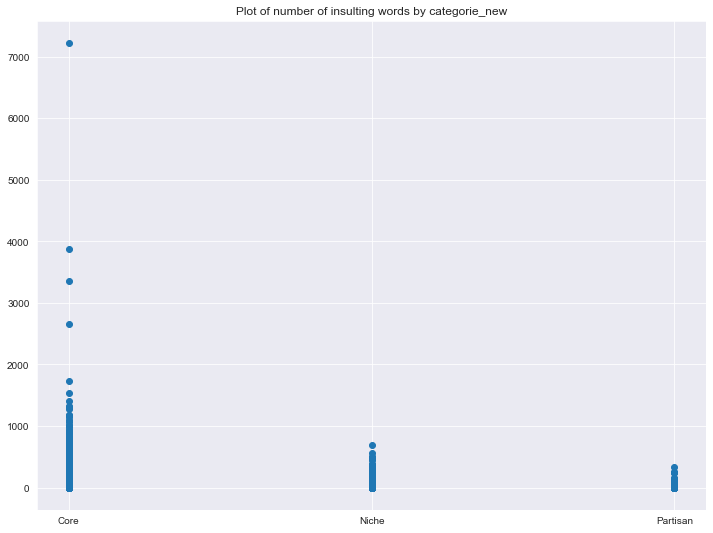

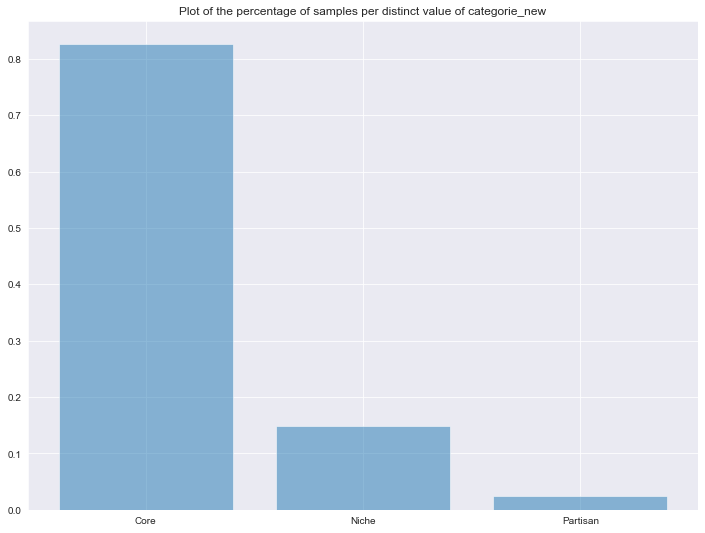

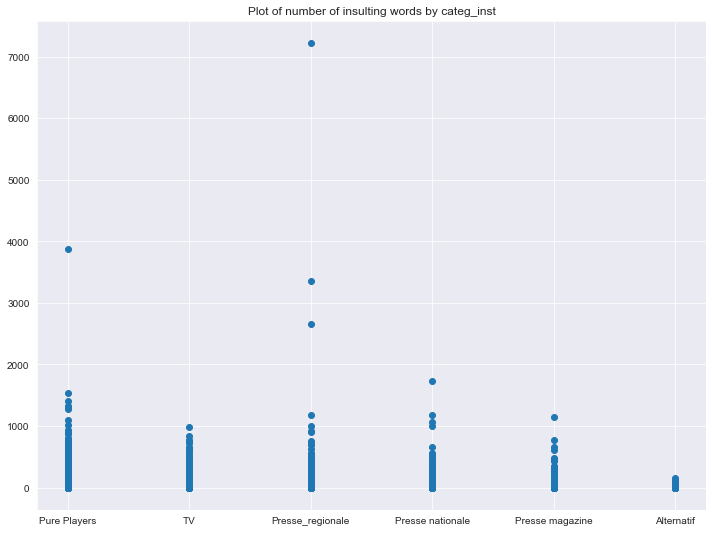

In [9]:
describe_cat_data(df)

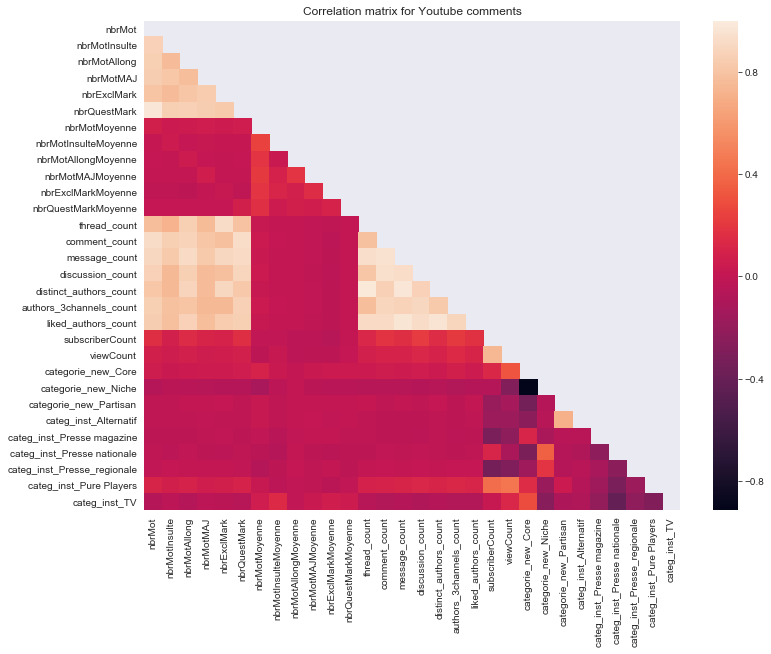

In [10]:
df_corr = one_hot_encoding(df)
correlation_matrix(df_corr)

# Regression on dataset with outliers limit

<Figure size 864x648 with 0 Axes>

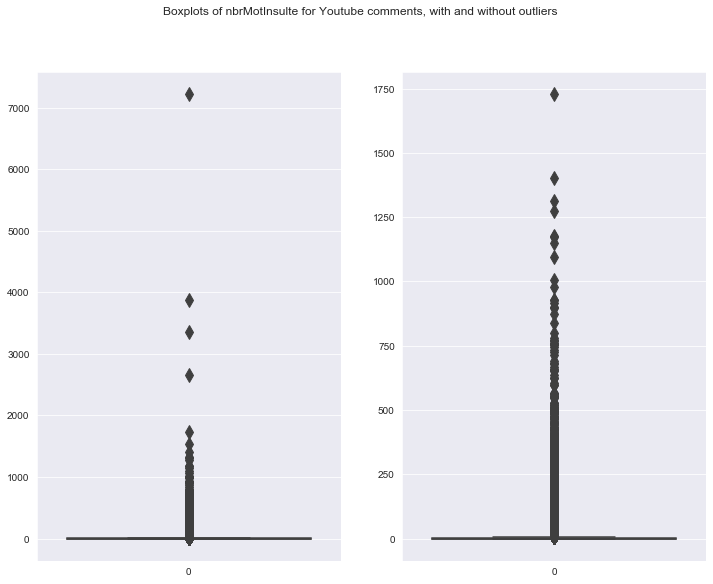

<Figure size 864x648 with 0 Axes>

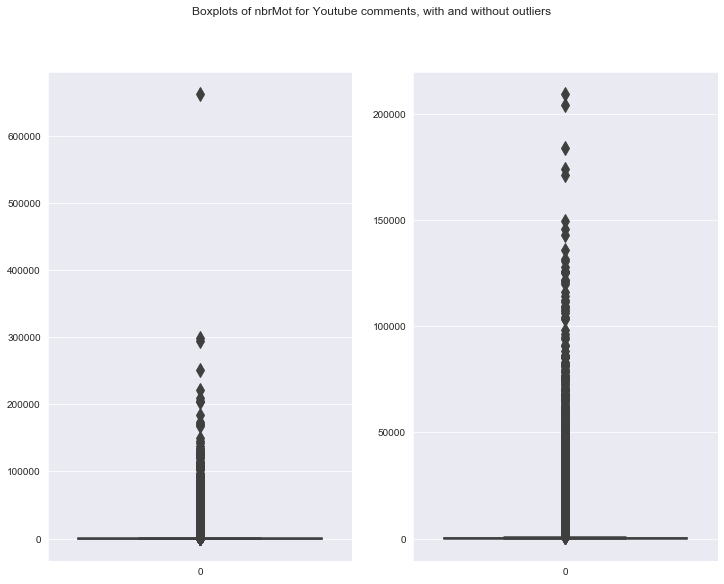

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

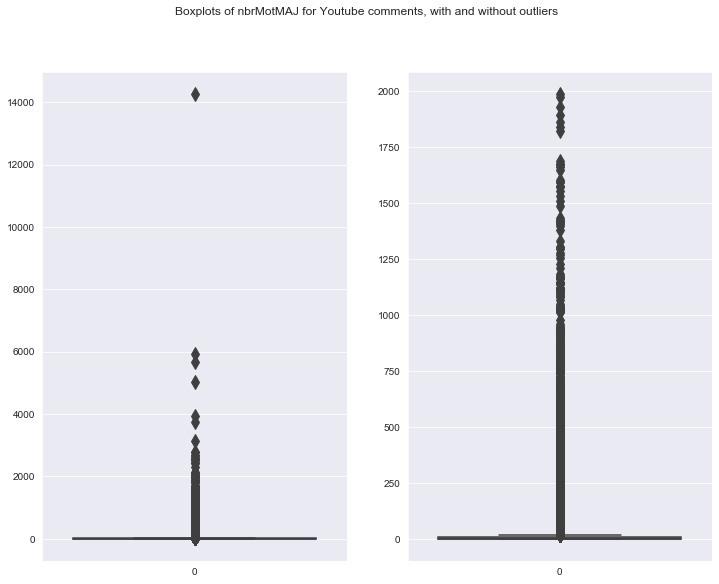

<Figure size 864x648 with 0 Axes>

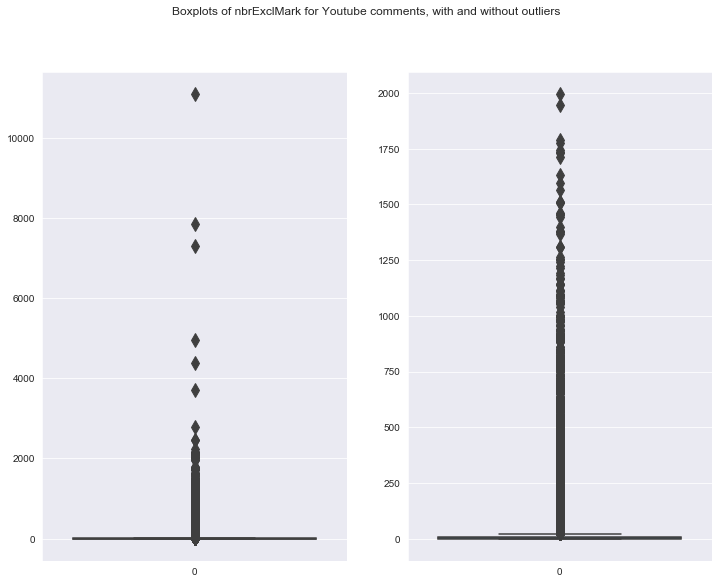

<Figure size 864x648 with 0 Axes>

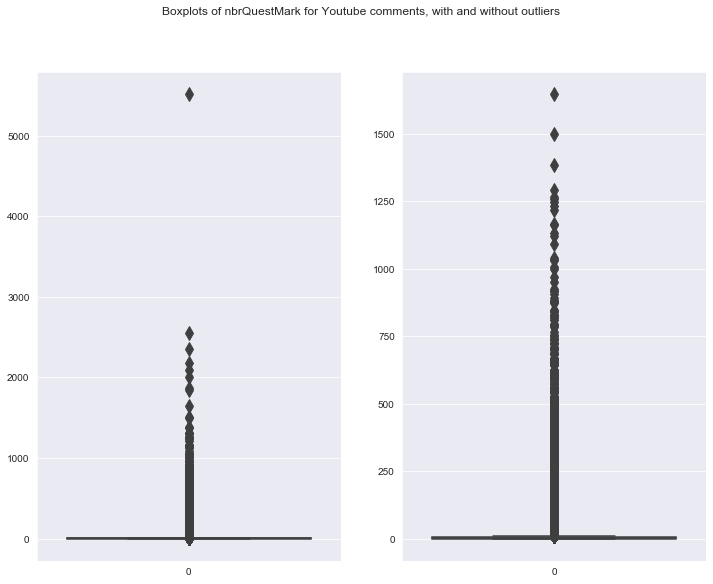

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

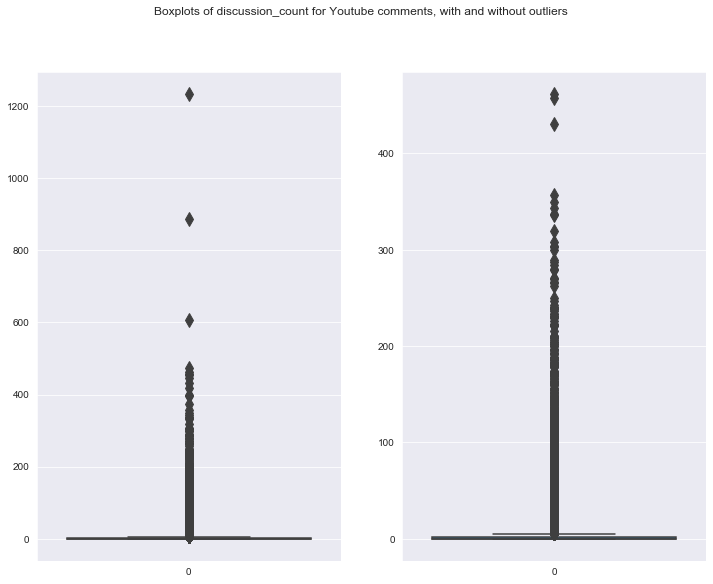

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

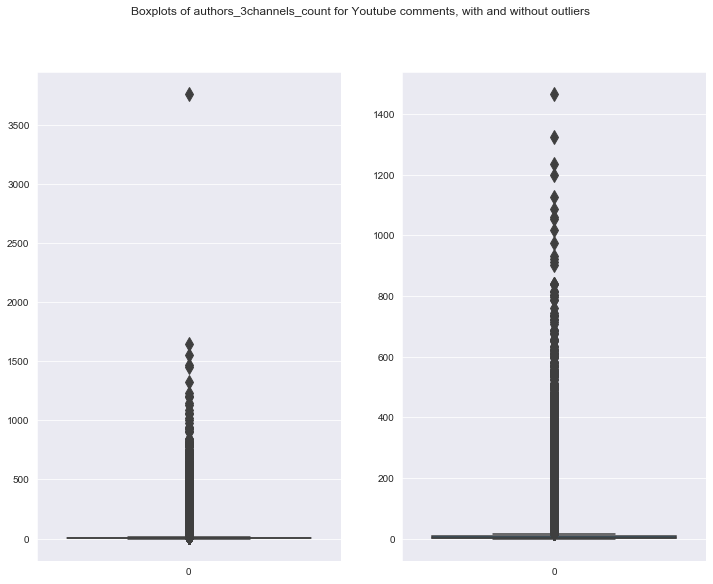

<Figure size 864x648 with 0 Axes>

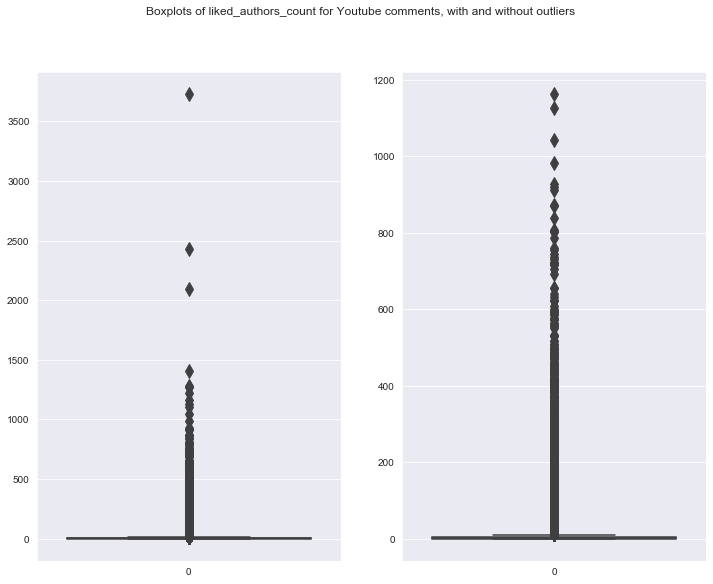

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

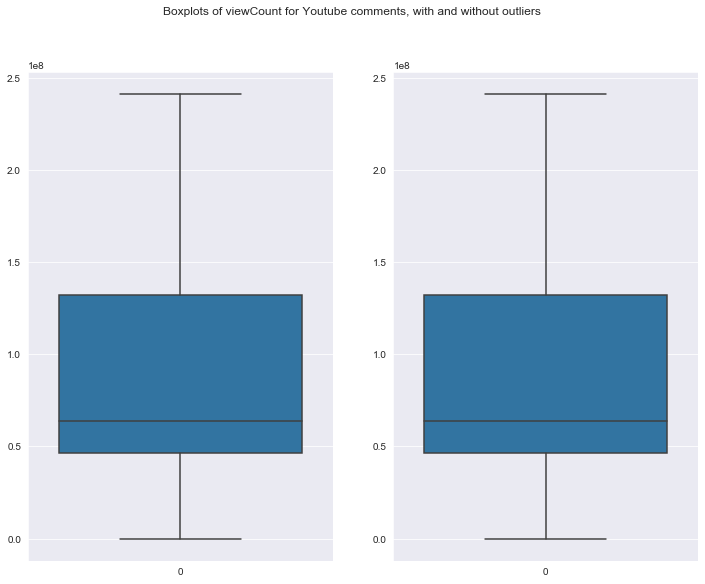

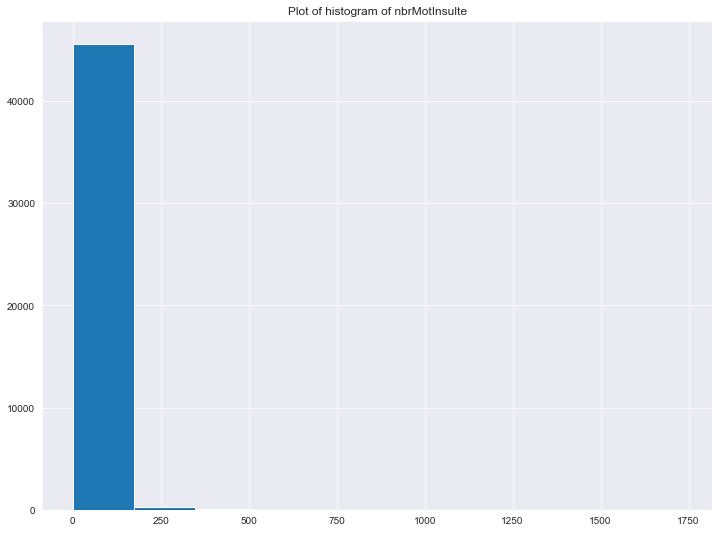

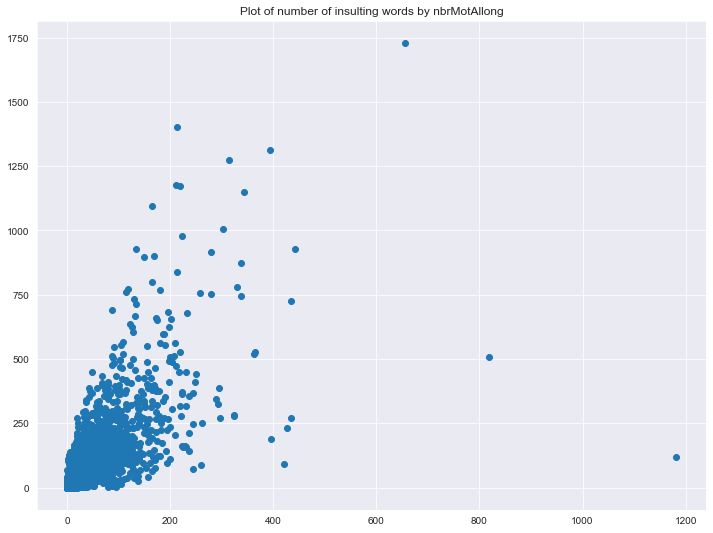

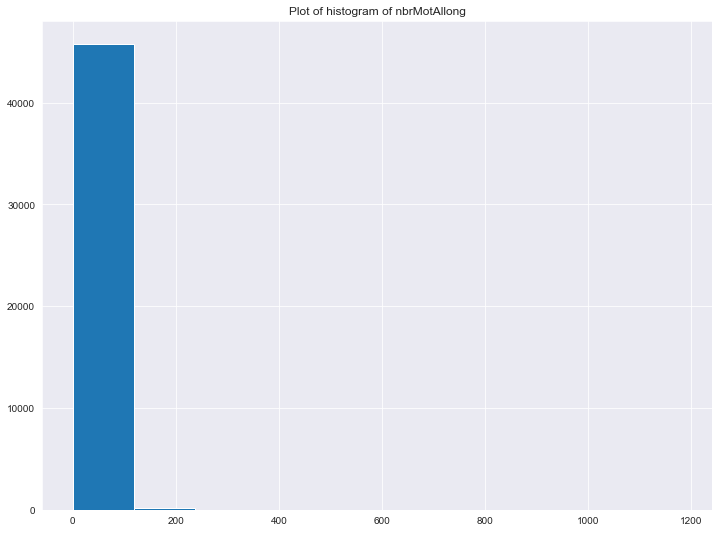

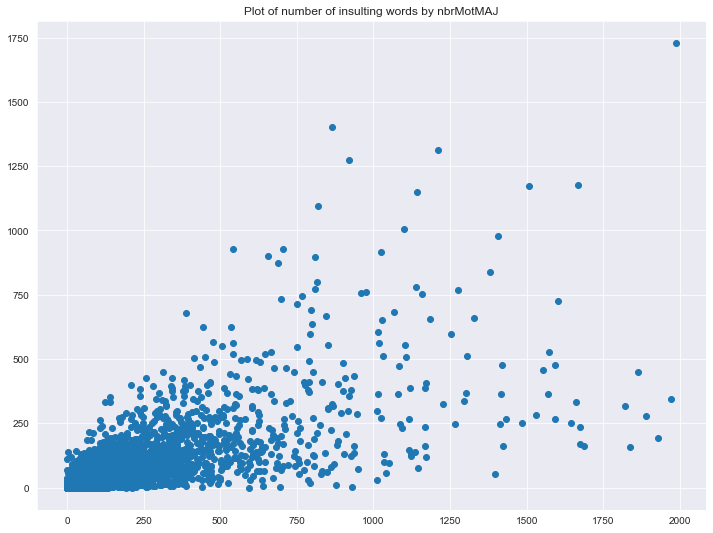

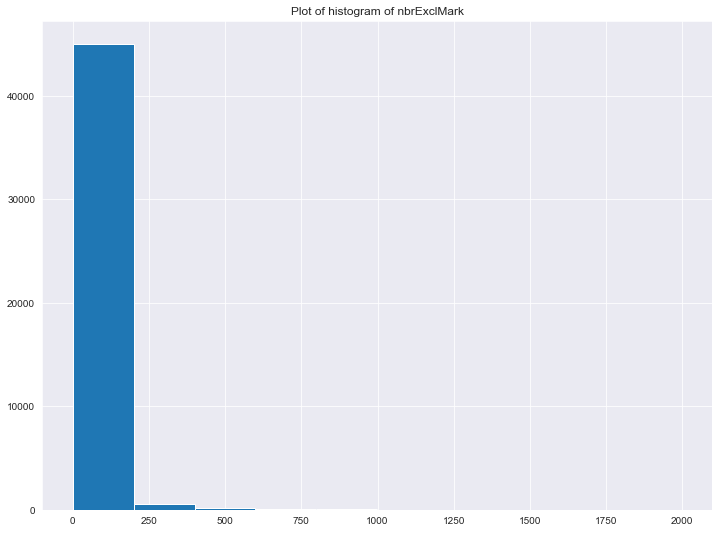

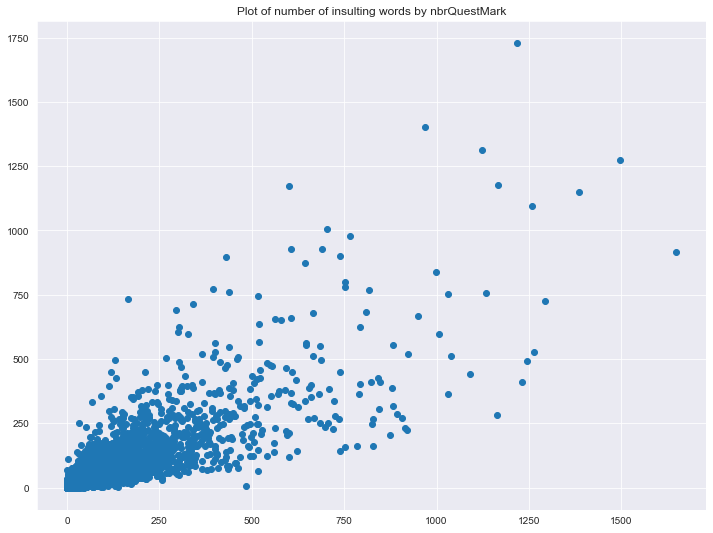

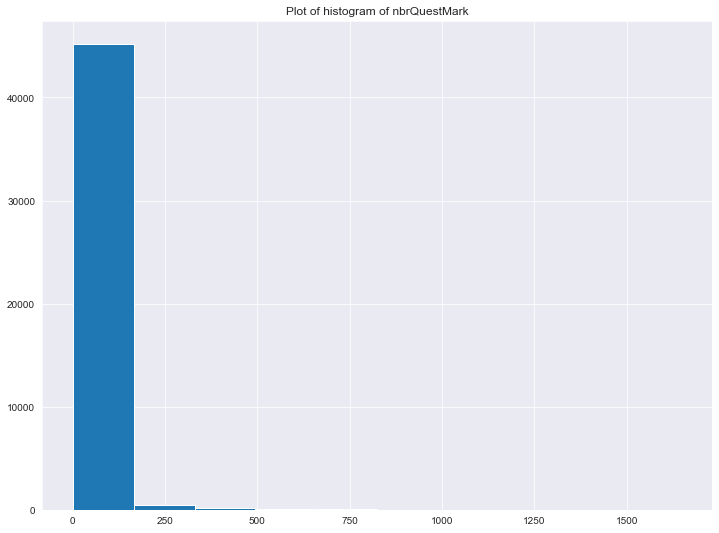

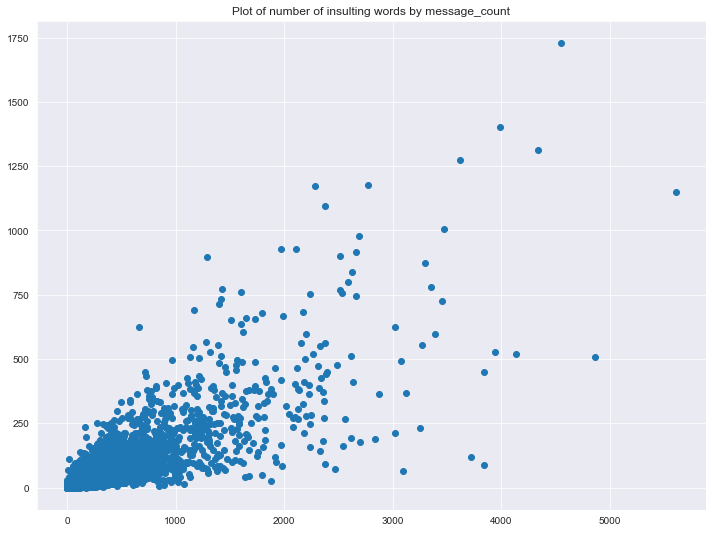

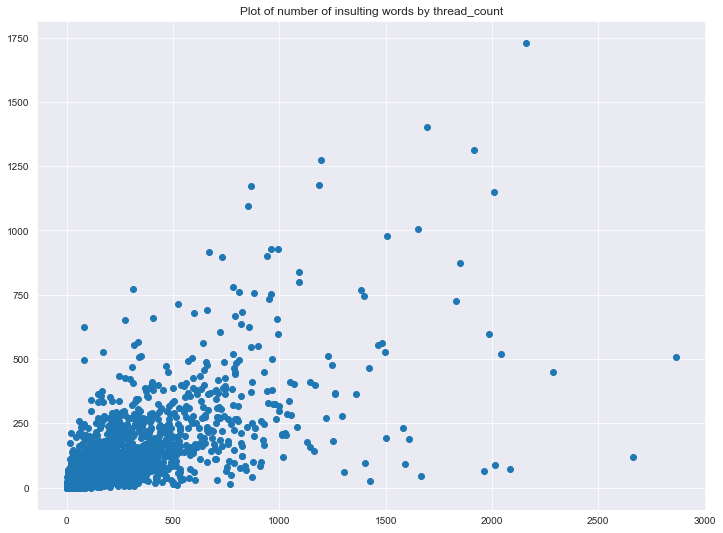

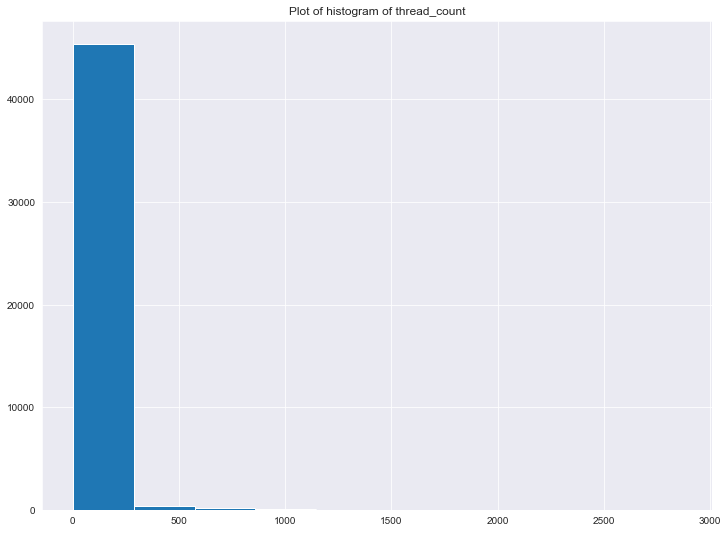

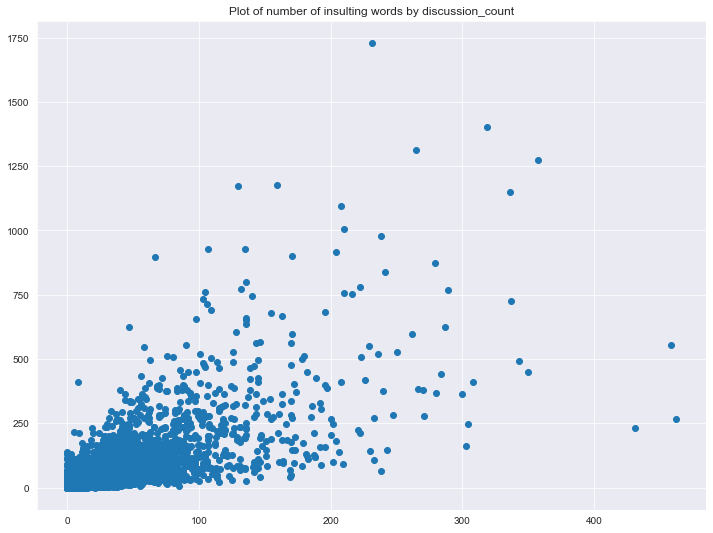

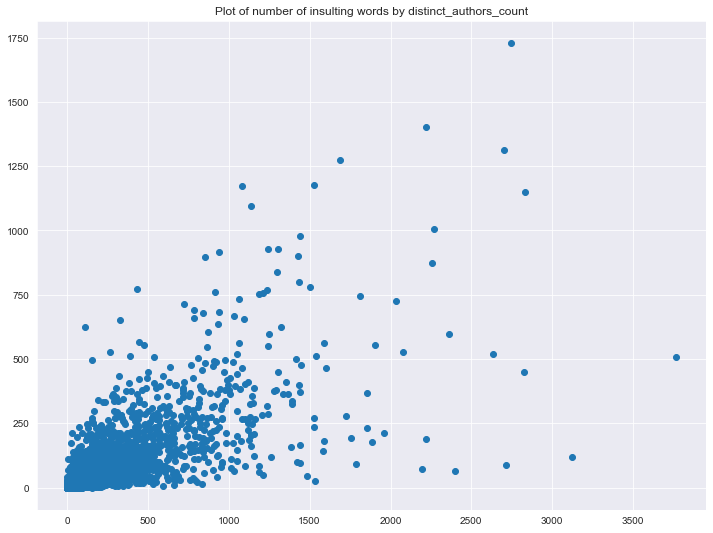

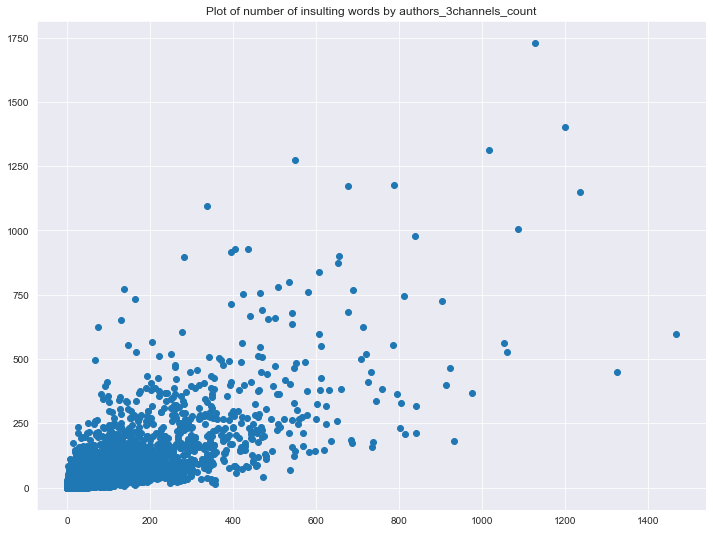

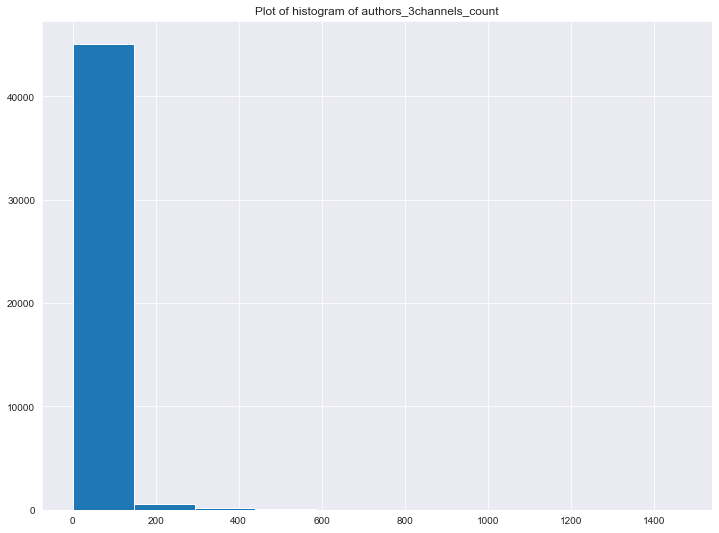

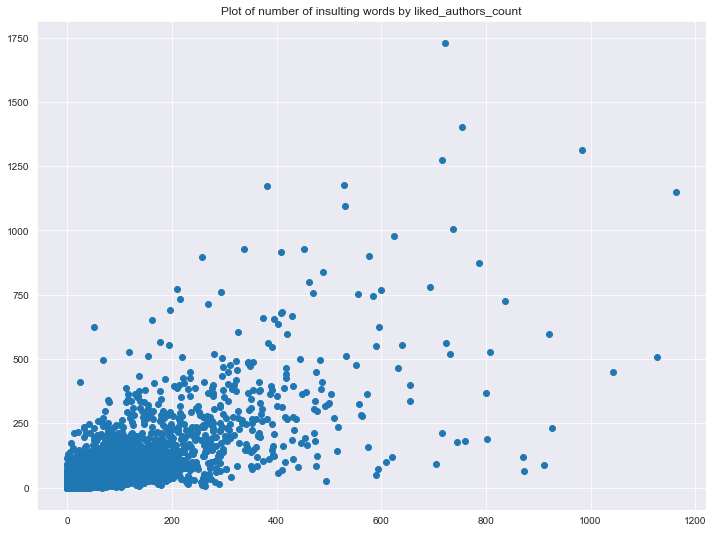

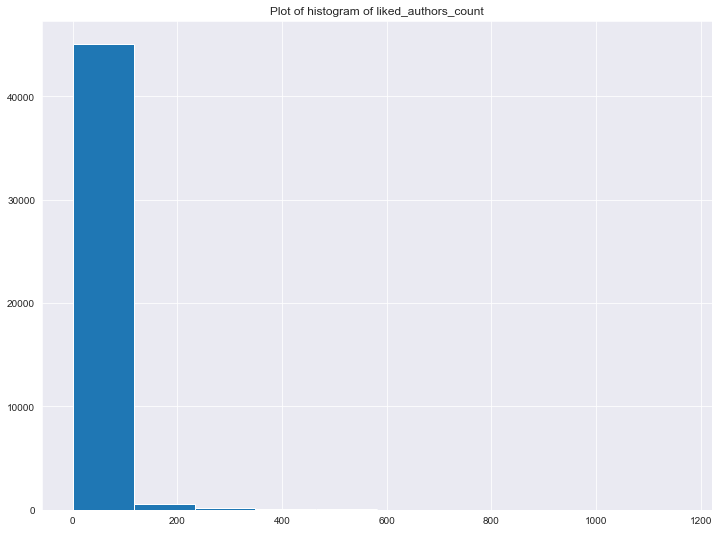

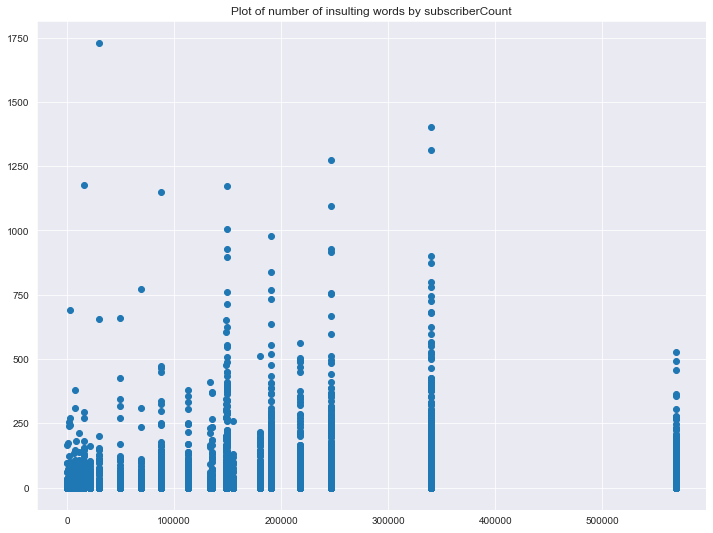

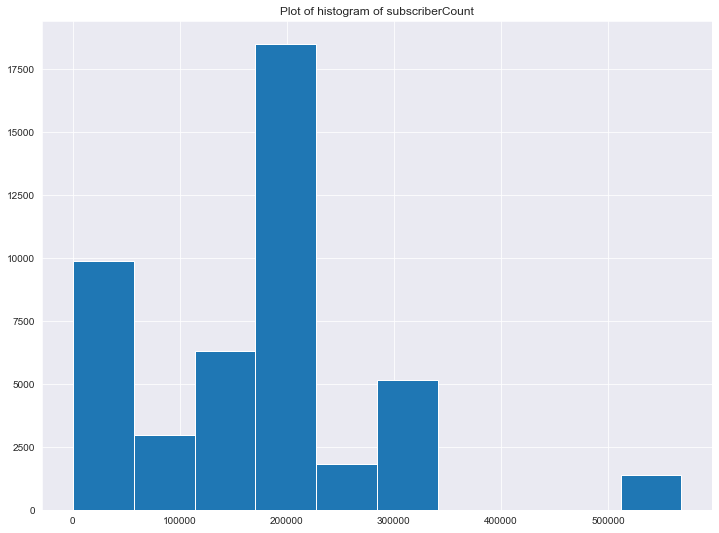

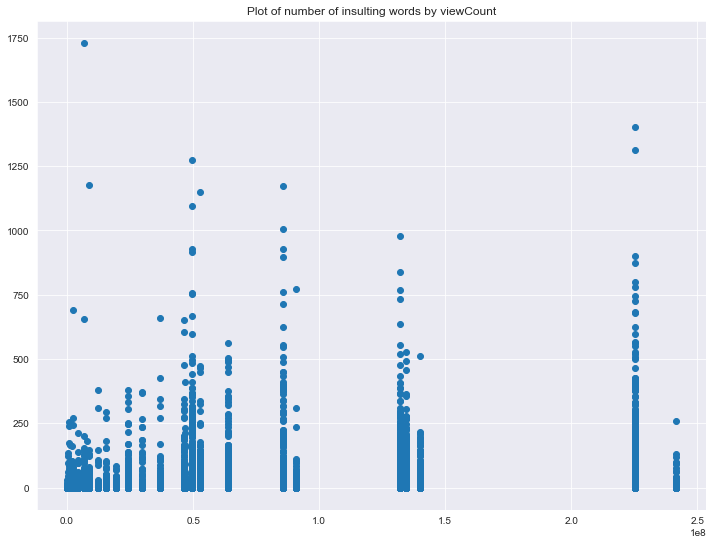

KeyboardInterrupt: 

In [11]:
X_train, Y_train, X_test, Y_test = create_dataset(plot=True, log=False)

In [ ]:
scores_on_train = {}
mse_on_test = {}
r2_on_test = {}
ratio_on_test = {}

### KNN

In [ ]:
algo = neighbors.KNeighborsRegressor
reg = algo()
reg = parameter_tuning(reg, {'n_neighbors': [2, 3, 4, 5]}, cv=3)

In [ ]:
show_one_parameter(algo, 'n_neighbors', list(range(2, 8)), cv=3)

In [ ]:
plot_results(reg)

### Decision tree

In [ ]:
algo = tree.DecisionTreeRegressor
reg = algo()
reg = parameter_tuning(reg, {'max_depth': [25]}, cv=3)

In [ ]:
show_one_parameter(algo, 'max_depth', [10, 15, 20, 25, 30, 40, 50, 70, 100], cv=3)

In [ ]:
# ccp_alpha: Complexity parameter used for Minimal Cost-Complexity Pruning
show_one_parameter(algo, 'ccp_alpha', [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9], cv=3, kwargs={'max_depth': 30})

In [ ]:
plot_results(reg)

### Random forest

In [ ]:
algo = RandomForestRegressor
reg = algo()
reg = parameter_tuning(reg, {'n_estimators': [20, 30], 'max_depth': [30, 50], 'n_jobs': [3]}, cv=3)

In [ ]:
show_one_parameter(algo, 'n_estimators', [10, 20, 30], cv=3, kwargs={'n_jobs': 3})

In [ ]:
show_one_parameter(algo, 'max_depth', [20, 30, 50, 80], cv=3, kwargs={'n_jobs': 3, 'n_estimators': 100})

In [ ]:
plot_results(reg)

### Conclusion for regression with outliers limit

In [ ]:
# interpréter r2 avec les valeurs abusées (7000 par ex)

In [ ]:
compare_scores()

# Regression on transformed dataset (with logs)

In [ ]:
X_train, Y_train, X_test, Y_test = create_dataset(plot=True, log=True)

In [ ]:
df_corr_log = pd.concat([X_train, X_test])
y1 = pd.DataFrame(Y_train, columns=['nbrMotInsulte'])
y2 = pd.DataFrame(Y_test, columns=['nbrMotInsulte'])
y_corr = pd.concat([y1, y2])
df_corr_log = pd.concat([df_corr_log, y_corr], axis=1)
correlation_matrix(df_corr_log, log=True)
correlation_matrix(df_corr)

In [ ]:
scores_on_train = {}
mse_on_test = {}
r2_on_test = {}
ratio_on_test = {}

### KNN

In [ ]:
algo = neighbors.KNeighborsRegressor
reg = algo()
reg = parameter_tuning(reg, {'n_neighbors': [2, 3, 4, 5]}, cv=3)

In [ ]:
show_one_parameter(algo, 'n_neighbors', list(range(2, 8)), cv=3)

In [ ]:
plot_results(reg, True)

### Decision tree

In [ ]:
algo = tree.DecisionTreeRegressor
reg = algo()
reg = parameter_tuning(reg, {'max_depth': [25]}, cv=3)

In [ ]:
show_one_parameter(algo, 'max_depth', [10, 15, 20, 25, 30, 40, 50, 70, 100], cv=3)

In [ ]:
# ccp_alpha: Complexity parameter used for Minimal Cost-Complexity Pruning
show_one_parameter(algo, 'ccp_alpha', [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9], cv=3, kwargs={'max_depth': 30})

In [ ]:
plot_results(reg, True)

### Random forest

In [ ]:
algo = RandomForestRegressor
reg = algo()
reg = parameter_tuning(reg, {'n_estimators': [20, 30], 'max_depth': [30, 50], 'n_jobs': [3]}, cv=3)

In [ ]:
show_one_parameter(algo, 'n_estimators', [10, 20, 30], cv=3, kwargs={'n_jobs': 3})

In [ ]:
show_one_parameter(algo, 'max_depth', [20, 30, 50, 80], cv=3, kwargs={'n_jobs': 3, 'n_estimators': 100})

In [ ]:
plot_results(reg, True)

### Conclusion for regression with outliers limit

In [ ]:
# beaucoup mieux !

In [ ]:
compare_scores()